In [14]:
import os
import numpy as np

import keras
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

from keras.models import load_model
from keras import backend as K

from io import BytesIO
from PIL import Image
import cv2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import colors

import requests

K.set_learning_phase(0) #set the learning phase to not training

In [16]:
model = load_model('model.03-0.94.hdf5')

In [18]:
# Set the image generator
eval_datagen = ImageDataGenerator(rescale=1./255)
eval_dir = '../OCT2017/eval'
eval_generator = eval_datagen.flow_from_directory(eval_dir, target_size=(299, 299), \
                                                    batch_size=32, class_mode='categorical')
# Evaluate the model for a small set of images
loss = model.evaluate_generator(eval_generator, steps=10)
out = {}
for index, name in enumerate(model.metrics_names):
    print(name, loss[index])  
    

Found 134 images belonging to 4 classes.
loss 0.0306852026287
acc 1.0


In [19]:
# Utility functions
classes = ['CNV', 'DME', 'DRUSEN', 'NORMAL']
# Preprocess the input
# Rescale the values to the same range that was used during training 
def preprocess_input(x):
    x = img_to_array(x) / 255.
    return np.expand_dims(x, axis=0) 

# Prediction for an image path in the local directory
def predict_from_image_path(image_path):
    return predict_image(load_img(image_path, target_size=(299, 299)))

# Prediction for an image URL path
def predict_from_image_url(image_url):
    res = requests.get(image_url)
    im = Image.open(BytesIO(res.content))
    return predict_from_image_path(im.fp)
    
# Predict an image
def predict_image(im):
    x = preprocess_input(im)
    pred = np.argmax(model.predict(x))
    return pred, classes[pred]

In [20]:
def grad_CAM(image_path):
    im = load_img(image_path, target_size=(299,299))
    x = preprocess_input(im)
    pred = model.predict(x)
    
    # Predicted class index
    index = np.argmax(pred)
    
    # Get the entry of the predicted class
    class_output = model.output[:, index]
    
    # The last convolution layer in Inception V3
    last_conv_layer = model.get_layer('conv2d_94')
    # Has 192 channels
    nmb_channels = last_conv_layer.output.shape[3]

    # Gradient of the predicted class with respect to the output feature map of the 
    # the convolution layer with 192 channels
    grads = K.gradients(class_output, last_conv_layer.output)[0]   
    
    # Vector of shape (192,), where each entry is the mean intensity of the gradient over 
    # a specific feature-map channel”
    pooled_grads = K.mean(grads, axis=(0, 1, 2))

    # Setup a function to extract the desired values
    iterate = K.function(model.inputs, [pooled_grads, last_conv_layer.output[0]])
    # Run the function to get the desired calues
    pooled_grads_value, conv_layer_output_value = iterate([x])
    
    # Multiply each channel in the feature-map array by “how important this channel is” with regard to the 
    # predicted class
 
    for i in range(nmb_channels):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
    # The channel-wise mean of the resulting feature map is the heatmap of the class activation.
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    
    # Normalize the heatmap betwen 0 and 1 for visualization
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
       
    # Read the image again, now using cv2
    img = cv2.imread(image_path)
    # Size the heatmap to the size of the loaded image
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    # Convert to RGB
    heatmap = np.uint8(255 * heatmap)
    # Pseudocolor/false color a grayscale image using OpenCV’s predefined colormaps
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
 
    # Superimpose the image with the required intensity
    superimposed_img = heatmap * 0.5 + img   
    
    # Write the image
    plt.figure(figsize=(24,12))
    cv2.imwrite('./tmp.jpg', superimposed_img)
    plt.imshow(mpimg.imread('./tmp.jpg'))
    plt.show() 

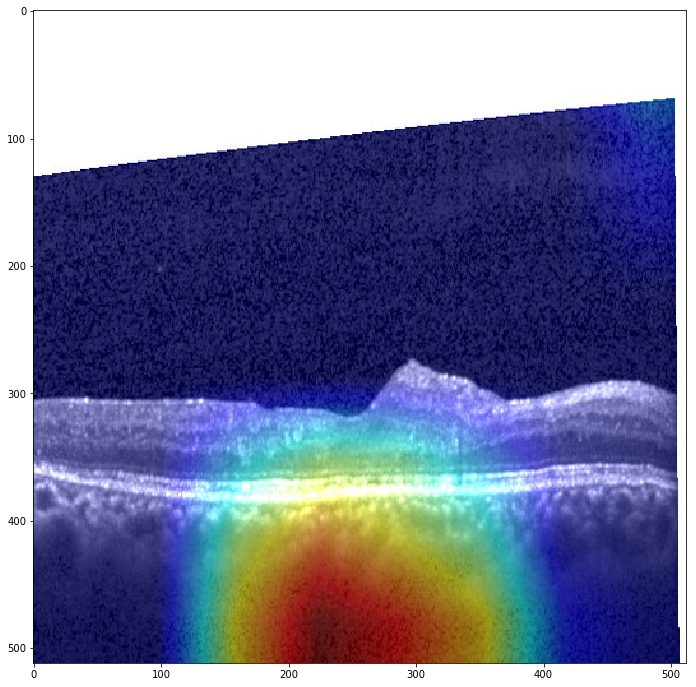

In [21]:
print(predict_from_image_path('../OCT2017/eval/DME/DME-15307-3.jpeg'))
grad_CAM('../OCT2017/eval/DME/DME-15307-3.jpeg')

(0, 'CNV')


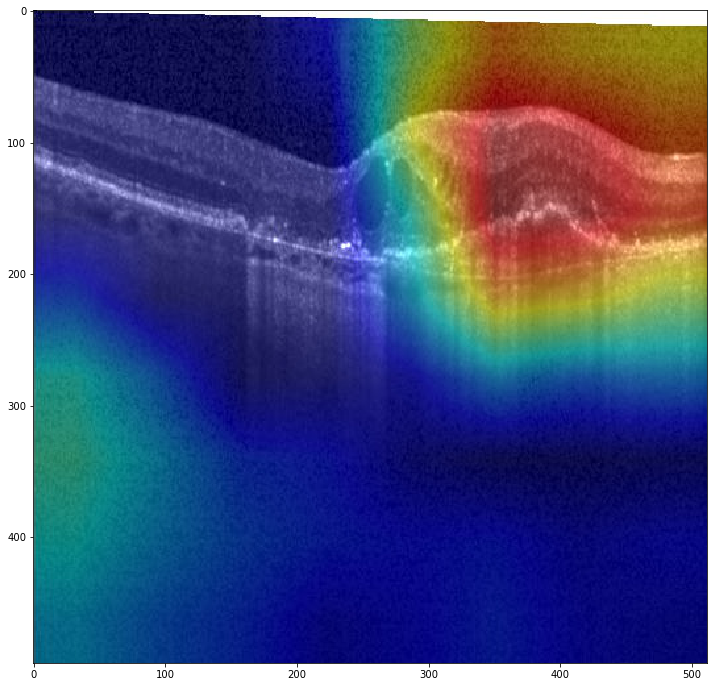

In [25]:
print(predict_from_image_path('../OCT2017/eval/CNV/CNV-103044-1.jpeg'))
grad_CAM('../OCT2017/eval/CNV/CNV-103044-1.jpeg')

(2, 'DRUSEN')


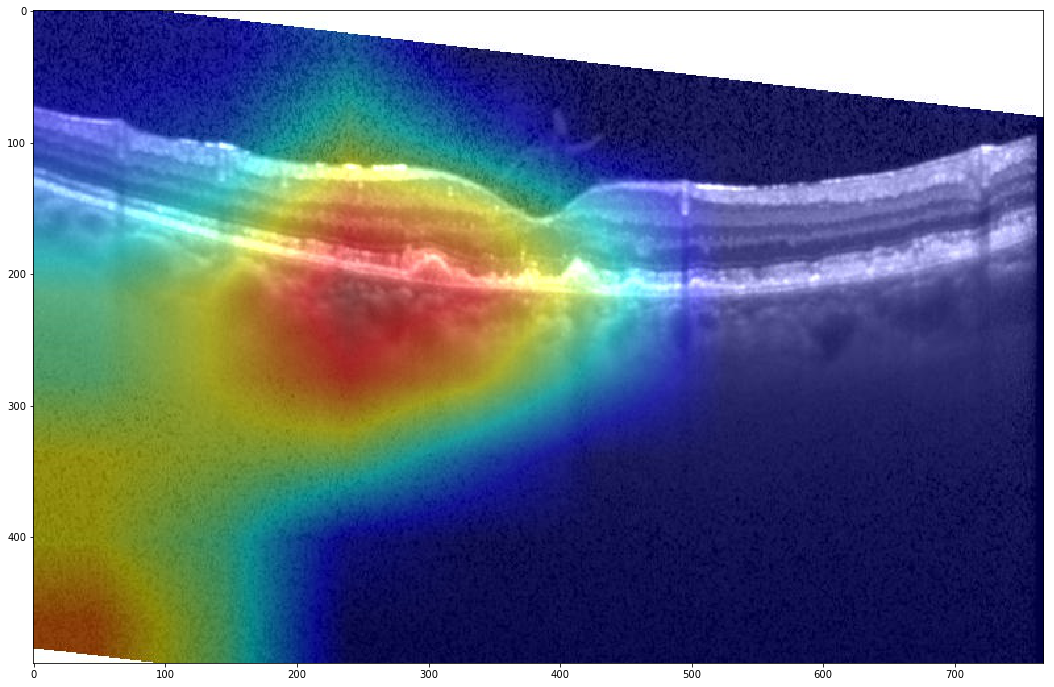

In [23]:
print(predict_from_image_path('../OCT2017/eval/DRUSEN/DRUSEN-53018-1.jpeg'))
grad_CAM('../OCT2017/eval/DRUSEN/DRUSEN-53018-1.jpeg')

(2, 'DRUSEN')


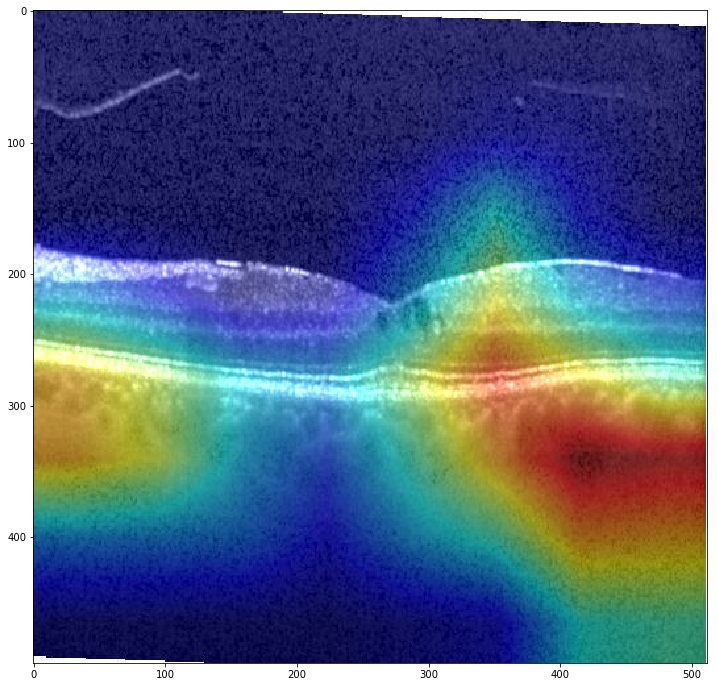

In [37]:
print(predict_from_image_path('./simple/test/DME/DME-11053-1.jpeg'))
grad_CAM('./simple/test/DME/DME-11053-1.jpeg')

CNV-103044-1.jpeg 0 CNV
CNV-103044-10.jpeg 0 CNV
CNV-103044-2.jpeg 0 CNV
CNV-103044-3.jpeg 0 CNV
CNV-103044-4.jpeg 0 CNV
CNV-103044-5.jpeg 0 CNV
CNV-103044-6.jpeg 0 CNV
CNV-103044-7.jpeg 0 CNV
CNV-103044-8.jpeg 0 CNV
CNV-103044-9.jpeg 0 CNV
CNV-53018-1.jpeg 0 CNV
CNV-53018-2.jpeg 0 CNV
CNV-81630-1.jpeg 0 CNV
CNV-81630-2.jpeg 0 CNV
CNV-81630-3.jpeg 0 CNV
CNV-81630-4.jpeg 0 CNV
DME-11053-1.jpeg 2 DRUSEN **INCORRECT PREDICTION**


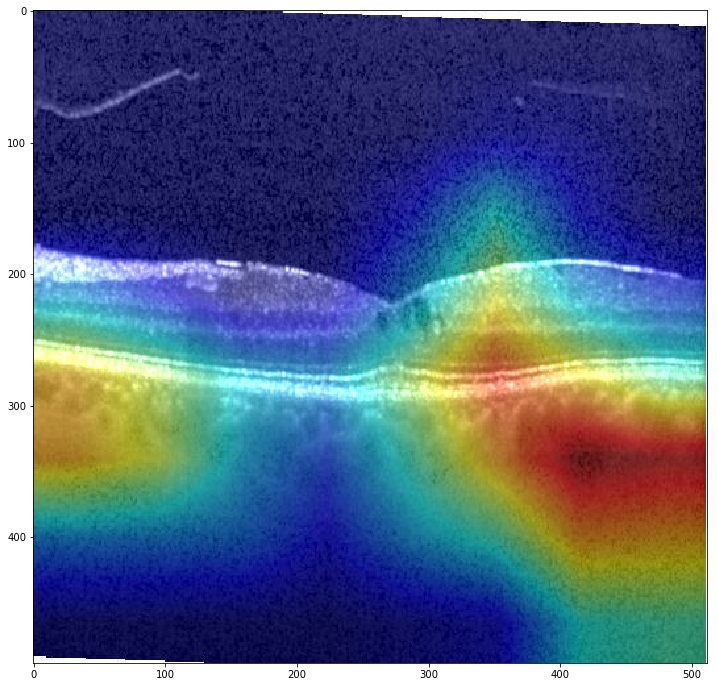

DME-15208-1.jpeg 1 DME
DME-15208-2.jpeg 0 CNV **INCORRECT PREDICTION**


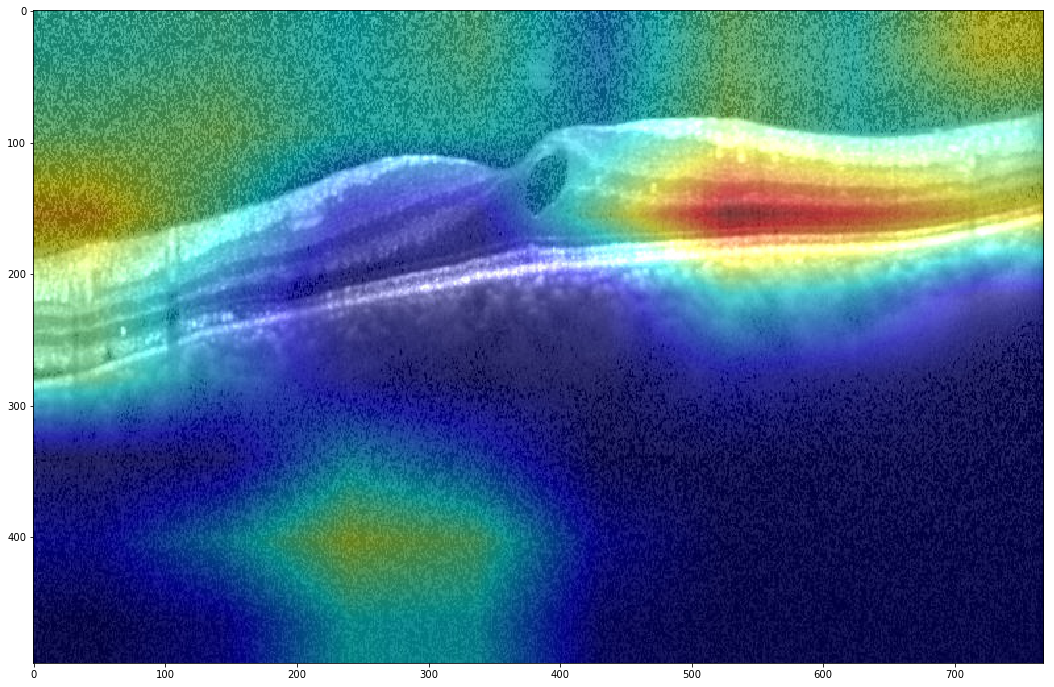

DME-30521-1.jpeg 1 DME
DME-30521-10.jpeg 1 DME
DME-30521-2.jpeg 1 DME
DME-30521-3.jpeg 2 DRUSEN **INCORRECT PREDICTION**


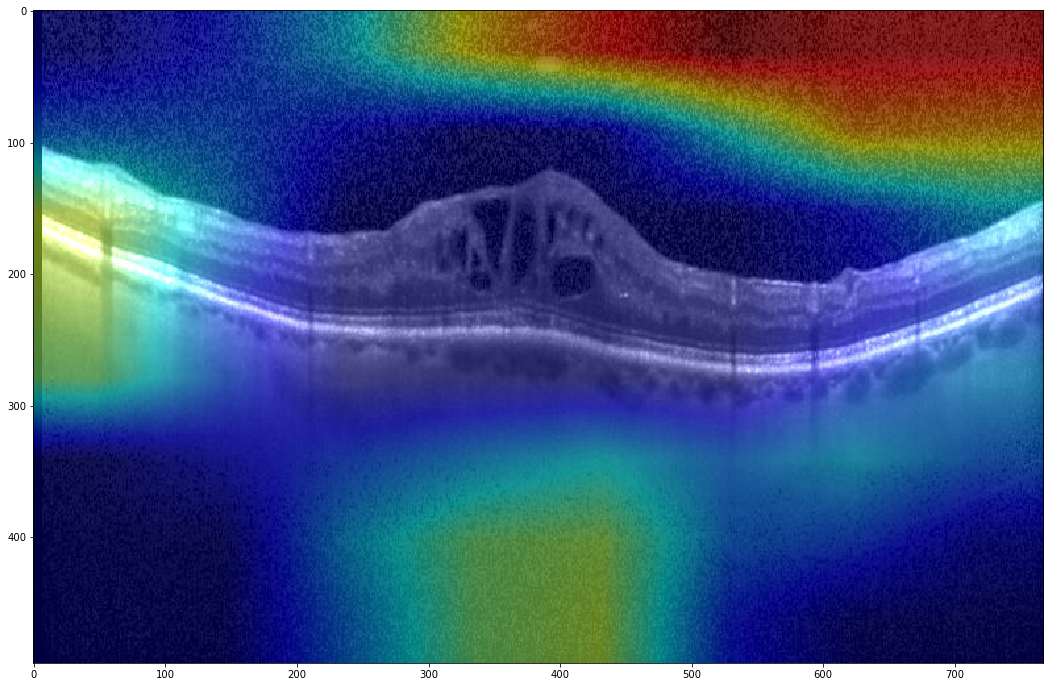

DME-30521-4.jpeg 1 DME
DME-30521-5.jpeg 1 DME
DME-30521-6.jpeg 1 DME
DME-30521-7.jpeg 1 DME
DME-30521-8.jpeg 1 DME
DME-30521-9.jpeg 1 DME
DRUSEN-228939-1.jpeg 2 DRUSEN
DRUSEN-228939-2.jpeg 2 DRUSEN
DRUSEN-303435-1.jpeg 2 DRUSEN
DRUSEN-349021-1.jpeg 2 DRUSEN
DRUSEN-349021-2.jpeg 2 DRUSEN
DRUSEN-364469-1.jpeg 2 DRUSEN
DRUSEN-364469-2.jpeg 2 DRUSEN
DRUSEN-364469-3.jpeg 2 DRUSEN
DRUSEN-364469-4.jpeg 2 DRUSEN
DRUSEN-457907-1.jpeg 2 DRUSEN
DRUSEN-525301-1.jpeg 2 DRUSEN
DRUSEN-95633-1.jpeg 2 DRUSEN
NORMAL-12494-1.jpeg 3 NORMAL
NORMAL-12494-2.jpeg 3 NORMAL
NORMAL-12494-3.jpeg 3 NORMAL
NORMAL-12494-4.jpeg 3 NORMAL
NORMAL-12494-5.jpeg 3 NORMAL
NORMAL-15208-1.jpeg 3 NORMAL
NORMAL-15307-1.jpeg 3 NORMAL
NORMAL-33350-1.jpeg 3 NORMAL
NORMAL-33350-2.jpeg 3 NORMAL
NORMAL-33350-3.jpeg 3 NORMAL
NORMAL-33637-1.jpeg 3 NORMAL
NORMAL-36734-1.jpeg 3 NORMAL
NORMAL-9251-1.jpeg 3 NORMAL


In [39]:
for i, c in enumerate(classes):
    folder = './simple/test/' + c + '/'
    count = 1
    for file in os.listdir(folder):
        if file.endswith('.jpeg') == True:
            image_path = folder + file
            p, class_name = predict_from_image_path(image_path)
            if p == i:
                print(file, p, class_name)
            else:
                print(file, p, class_name, '**INCORRECT PREDICTION**')
                grad_CAM(image_path)
        count = count +1
        if count == 100:
            continue               


In [40]:
predict_from_image_url('https://www.dropbox.com/s/tyy21hckkowt1p8/CNV-53018-1.jpeg?dl=1')

(0, 'CNV')